# Part 2: Neural Network

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

In [2]:
spam_data = pd.read_csv('spam_or_not_spam\spam_or_not_spam.csv', sep =',',names=["email", "label"], skiprows=1)
spam_data = spam_data.astype(str) # Read correctly the type of emails
spam_data.head()

,email,label
0,mike bostock said received from trackingNUMBE...,0
1,no i was just a little confused because i m r...,0
2,this is just an semi educated guess if i m wro...,0
3,jm URL justin mason writes except for NUMBER t...,0
4,i just picked up razor sdk NUMBER NUMBER and N...,0


# Handling imbalanced data


In [3]:
# Replace binary labels with 'good' and 'spam" labels
spam_data['label'] = spam_data['label'].replace('0','good')
spam_data['label'] = spam_data['label'].replace('1','spam')

In [4]:
# Gather all the good and spam emails in 2 different datasets
good_email = spam_data[spam_data.label=='good']
spam_email = spam_data[spam_data.label=='spam']
spam_data.head()

,email,label
0,mike bostock said received from trackingNUMBE...,good
1,no i was just a little confused because i m r...,good
2,this is just an semi educated guess if i m wro...,good
3,jm URL justin mason writes except for NUMBER t...,good
4,i just picked up razor sdk NUMBER NUMBER and N...,good


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


50.0

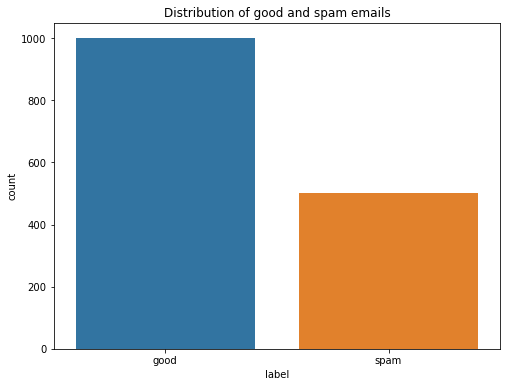

In [5]:
# we can observe imbalance in the data here 
plt.figure(figsize=(8,6))
plt.title('Distribution of good and spam emails')
sns.countplot(spam_data.label)
# Percentage of spam emails
(len(spam_email)/len(good_email))*100 # 50%

In [6]:
# One way to fix it is to downsample the good emails
good_email_df = good_email.sample(n = len(spam_email), random_state = 33)
spam_email_df = spam_email
print(good_email_df.shape, spam_email_df.shape)

(500, 2) (500, 2)


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

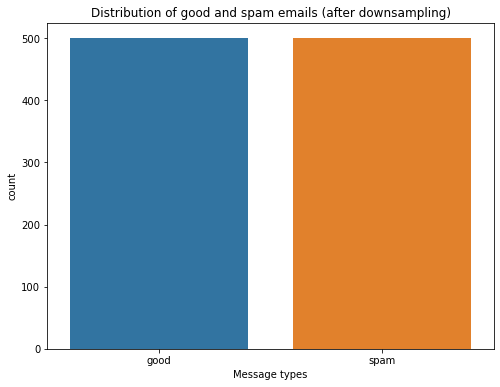

In [7]:
# Create a dataframe with good and spam email
email_df = good_email_df.append(spam_email_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(email_df.label)
plt.title('Distribution of good and spam emails (after downsampling)')
plt.xlabel('Message types')

In [8]:
# Replace labels with binary information suitable for training in the NN
email_df['label'] = email_df['label'].replace('good','0')
email_df['label'] = email_df['label'].replace('spam','1')
email_df.tail()

,email,label
995,abc s good morning america ranks it the NUMBE...,1
996,hyperlink hyperlink hyperlink let mortgage le...,1
997,thank you for shopping with us gifts for all ...,1
998,the famous ebay marketing e course learn to s...,1
999,hello this is chinese traditional 子 件 NUMBER世...,1


# Prepare train/test data and pre-process text


In [9]:
# Change the data type of the target column to int
email_df["label"] = email_df["label"].astype(str).astype(int)
# (fixes the "Cast string to float is not supported" issue)

In [10]:
# convert label to numpy arrays to fit deep learning models
email_labels = email_df['label'].values

In [11]:
# Split data into train and test (75% + 25%)
train_emails, test_emails, train_labels, test_labels = train_test_split(email_df['email'], email_labels, test_size=0.25, random_state=434)

#### As deep learning models do not understand text, let’s convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer() does all the required pre-processing such as tokenize into word or character — here we use at word level num_words for maximum number of unique tokens hence we can filter out rare words, filter out punctuation terms, convert all words to lower case, convert all words to integer index

In [12]:
# Defining pre-processing hyperparameters
max_len = 100 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 18000

In [13]:
# Tokenize the words
tokenizer = Tokenizer(num_words = vocab_size, lower=True, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_emails)

In [14]:
# Get the word_index 
word_index = tokenizer.word_index
# Check how many words 
total_words = len(word_index)
print('There are %s unique words (tokens)  in training data. ' % total_words)

There are 17179 unique words (tokens)  in training data. 


#### After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length. Sequencing and padding are done for both training and testing data.

# Sequencing and Padding


In [15]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_emails)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_emails)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [16]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (750, 100)
Shape of testing tensor:  (250, 100)


In [17]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(11599, 576)

In [18]:
# After padding
len(training_padded[0]), len(training_padded[1])

(100, 100)

In [19]:
# Padded sequence of a first sentence
print(training_padded[0])

[ 178   50   51   90   22  148    9  871  674   73 1250  220    2    2
    2 2901    4 7542    9  159 2299   15  148 2902 1608 2300  178   50
   51   90   22  148    9  871  674   73 1250  220    2    2    2 2901
    4 2301    9  159 2299   15  148 2902 1608 2300  178   50   51   90
   22  148    9  871  674   73 2063  220    2    2    2 1195    4 7543
    9  159 1879  148 2902 1608 2300  178   50   51   90   22  148    9
  871  674   73 1250 3318    2    2    2 2901    4 7544    9  159 2299
   15  148]


 # Training the model using a Dense architecture

In [20]:
# Define hyper-parameters:
vocab_size = 18000 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [21]:
# Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           288000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 288,433
Trainable params: 288,433
Non-trainable params: 0
_________________________________________________________________


# Define Metrics

In [23]:
from keras import backend as K
# Define manually our desired metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile and fit the model

In [24]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

# fit the model
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks = [early_stop], verbose=2)

Epoch 1/40
24/24 - 1s - loss: 0.6888 - accuracy: 0.6333 - f1_m: 0.4313 - precision_m: 0.6996 - recall_m: 0.3616 - val_loss: 0.6833 - val_accuracy: 0.8400 - val_f1_m: 0.8155 - val_precision_m: 0.9016 - val_recall_m: 0.7545
Epoch 2/40
24/24 - 0s - loss: 0.6744 - accuracy: 0.8040 - f1_m: 0.7842 - precision_m: 0.8449 - recall_m: 0.7437 - val_loss: 0.6631 - val_accuracy: 0.8680 - val_f1_m: 0.8531 - val_precision_m: 0.9251 - val_recall_m: 0.8023
Epoch 3/40
24/24 - 0s - loss: 0.6444 - accuracy: 0.8547 - f1_m: 0.8365 - precision_m: 0.9457 - recall_m: 0.7553 - val_loss: 0.6283 - val_accuracy: 0.8720 - val_f1_m: 0.8576 - val_precision_m: 0.9257 - val_recall_m: 0.8092
Epoch 4/40
24/24 - 0s - loss: 0.5992 - accuracy: 0.8733 - f1_m: 0.8503 - precision_m: 0.9573 - recall_m: 0.7730 - val_loss: 0.5791 - val_accuracy: 0.8920 - val_f1_m: 0.8784 - val_precision_m: 0.9593 - val_recall_m: 0.8170
Epoch 5/40
24/24 - 0s - loss: 0.5417 - accuracy: 0.8880 - f1_m: 0.8760 - precision_m: 0.9786 - recall_m: 0.8014 

# Evaluation

In [25]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(testing_padded, test_labels, verbose=0)

In [26]:
print(loss, accuracy, f1_score, precision, recall)

0.047405075281858444 0.9879999756813049 0.9876344203948975 1.0 0.9765625


In [27]:
print("------- Metrics -------")
print(f"Loss: {loss} \nAccuracy: {accuracy} \nF1_score: {f1_score} \nPrecision: {precision} \nRecall: {recall}")

------- Metrics -------
Loss: 0.047405075281858444 
Accuracy: 0.9879999756813049 
F1_score: 0.9876344203948975 
Precision: 1.0 
Recall: 0.9765625


In [28]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

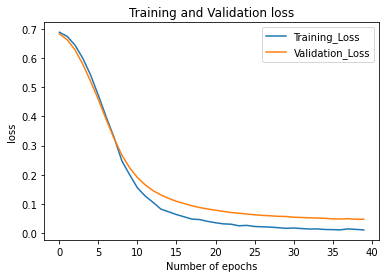

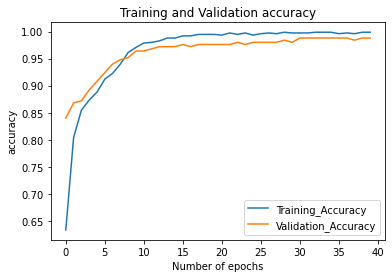

In [29]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Prediction of spam emails

# Scenario 1: Using raw text from our data:


In [30]:
# display long string 
pd.options.display.max_colwidth=200
email_df[:1200]

,email,label
0,use perl daily headline mailer perl NUMBER right here right now slides ava posted by gnat on friday september NUMBER NUMBER NUMBER news URL copyright NUMBER NUMBER pudge all rights reserved you ha...,0
1,url URL date wed NUMBER sep NUMBER NUMBER NUMBER NUMBER gmt ken dow reports NUMBER that the current version of omnioutliner can read and write opml this means for example with a little radio scrip...,0
2,anthony baxter NUMBER sets each of NUMBERham NUMBERspam just ran the once it matched all NUMBER to each other URL sez training on data ham setNUMBER data spam setNUMBER NUMBER hams NUMBER spams N...,0
3,i just picked up razor sdk NUMBER NUMBER and NUMBER NUMBER agents from the the razor site i am using suse NUMBER NUMBER intalled sdk with no problems all tests passed when i try to make the NUMBER...,0
4,url URL date tue NUMBER sep NUMBER NUMBER NUMBER NUMBER gmt iowa NUMBER there was frost outside this morning NUMBER URL,0
...,...,...
995,abc s good morning america ranks it the NUMBER christmas toy of the season the new NUMBER inch mini remote control cars are out of stock everywhere parents are searching frantically but having no...,1
996,hyperlink hyperlink hyperlink let mortgage lenders compete for your business did you receive an email advertisement in error our goal is to only target individuals who would like to take advantag...,1
997,thank you for shopping with us gifts for all occasions free gift with NUMBER NUMBER purchase for a limited time only receive this NUMBER plush santa bear free with your purchase of NUMBER NUMBER ...,1
998,the famous ebay marketing e course learn to sell with the complete ebay auction marketing e course here s your chance to join the online selling revolution and earn a full time income our ebay ma...,1


In [31]:
# Defining prediction function
def predict_spam(predict_email):
    new_seq = tokenizer.texts_to_sequences(predict_email)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [32]:
predict_email = ["the famous ebay marketing e course learn to sell with the complete ebay auction marketing ",
          "current version of omnioutliner can read and write opml this means",
          "hello this is chinese traditional"]

In [33]:
predict_spam(predict_email)

array([[0.94956553],
       [0.5066295 ],
       [0.6872786 ]], dtype=float32)

# Scenario 2: Using newly created text and see how the model classifies them.

In [34]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_email = ["You are awarded a new Digital Camera! Call now!",
               "It was nice meeting you at the University",
          "with this top of the line software norton systemworks"]
predict_spam(predict_email)

array([[0.83897007],
       [0.53395385],
       [0.8193152 ]], dtype=float32)

# Summary / Observations:

#### Our model seems to be highly accurate when it comes to predicting spam email related to the dataset. The certainty of a prediction increases if we input more words in the email. In the instances of few words, the model is more probable to consider the content as spam. In the case of randomly created messages it has a hard time predicting spam email, either because of the fewer words or a generally different format/style than the one used in our csv data. The neural network is accustomed to data similar to the ones used for the training, which are insufficient for it to be an accurate predictor of generally potential spam emails.